In [ ]:
# To use in Google Colab or Kaggle Notebooks
!pip install datasets==2.14.5
!pip install torch==2.0.0
!pip install transformers==4.34.0
!pip install tqdm==4.66.1
!pip install tokenizers==0.14.1
!pip install pandas==2.0.3
!pip install scikit-learn==1.3.0
!pip install matplotlib==3.8.0
!pip install --upgrade numpy==1.22.4

In [13]:
# Importing Libraries
from datasets import load_dataset
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import accuracy_score
from enum import Enum
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

# Use GPU if available
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
dataset = load_dataset("multi_woz_v22")
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

No config specified, defaulting to: multi_woz_v22/v2.2_active_only
Found cached dataset multi_woz_v22 (C:/Users/berna/.cache/huggingface/datasets/multi_woz_v22/v2.2_active_only/2.2.0/6719c8b21478299411a0c6fdb7137c3ebab2e6425129af831687fb7851c69eb5)


  0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
speaker_str = {0: 'User', 1: 'Agent'}
PAST_HISTORY_LENGTH = 2

# Change the label of the dialogue act which has the following structure: domain-act to domain if the domain is not
# one of the [Restaurant, Hotel, Booking, General]
def relabel_dialogue_act(dialogue_act: str):
    if dialogue_act.split('-')[0].upper() not in ['RESTAURANT', 'HOTEL', 'BOOKING', 'GENERAL']:
        new_dialog_act = dialogue_act.split('-')[0]
    else:
        new_dialog_act = dialogue_act

    return new_dialog_act


def toDataFrame(raw_data):
    # Initialize an empty list to store rows as dictionaries
    data = []

    # Loop through each dialogue in the training data
    for dialogue in raw_data:

        # Get the number of turns in this dialogue
        num_turns = len(dialogue['turns']['utterance'])

        # Initialize the history of the user and agent as lists with ("", []) for the number of PAST_HISTORY_LENGTH elements
        previous_user_history = [("",[]) for i in range(PAST_HISTORY_LENGTH)]
        previous_agent_history = [("",[]) for i in range(PAST_HISTORY_LENGTH)]

        # Loop through each turn in the dialogue
        for i in range(num_turns):
            speaker = speaker_str[dialogue['turns']['speaker'][i]]

            # Extract the utterance and corresponding dialog act for this turn
            utterance = dialogue['turns']['utterance'][i]
            dialogue_act = dialogue['turns']['dialogue_acts'][i]['dialog_act']['act_type']

            # Relabel the dialogue act 
            dialogue_act_new = []
            for act in dialogue_act:
                dialogue_act_new.append(relabel_dialogue_act(act))

            dialogue_act = dialogue_act_new

            if speaker == 'User':
                # Encode the history of the user and agent as a string
                encoded_history = ""
                for j in range(len(previous_user_history)):
                    encoded_history += ">".join([previous_user_history[j][0], "_".join(previous_user_history[j][1])]) + "|"
                for j in range(len(previous_agent_history)):
                    encoded_history += ">".join([previous_agent_history[j][0], "_".join(previous_agent_history[j][1])]) + "|"
                encoded_history = encoded_history + utterance

                # Append as a dictionary to the data lis
                data.append({'EncodedHistory': encoded_history, 'DialogueAct': dialogue_act})

                
                previous_user_history.append((utterance, dialogue_act))
                if len(previous_user_history) > PAST_HISTORY_LENGTH:
                    previous_user_history.pop(0)
            elif speaker == 'Agent':
                previous_agent_history.append((utterance, dialogue_act))

                if len(previous_agent_history) > PAST_HISTORY_LENGTH:
                    previous_agent_history.pop(0)

    # Save data as pandas df
    df = pd.DataFrame(data)

    # Separate features and labels
    X = df['EncodedHistory']
    Y = df['DialogueAct']
    
    return X, Y
        
X_train, Y_train = toDataFrame(train_data)
X_val, Y_val = toDataFrame(val_data)
X_test, Y_test = toDataFrame(test_data)

# Final Training
X_test_val = pd.concat([X_test,X_val])
Y_test_val = pd.concat([Y_test, Y_val])

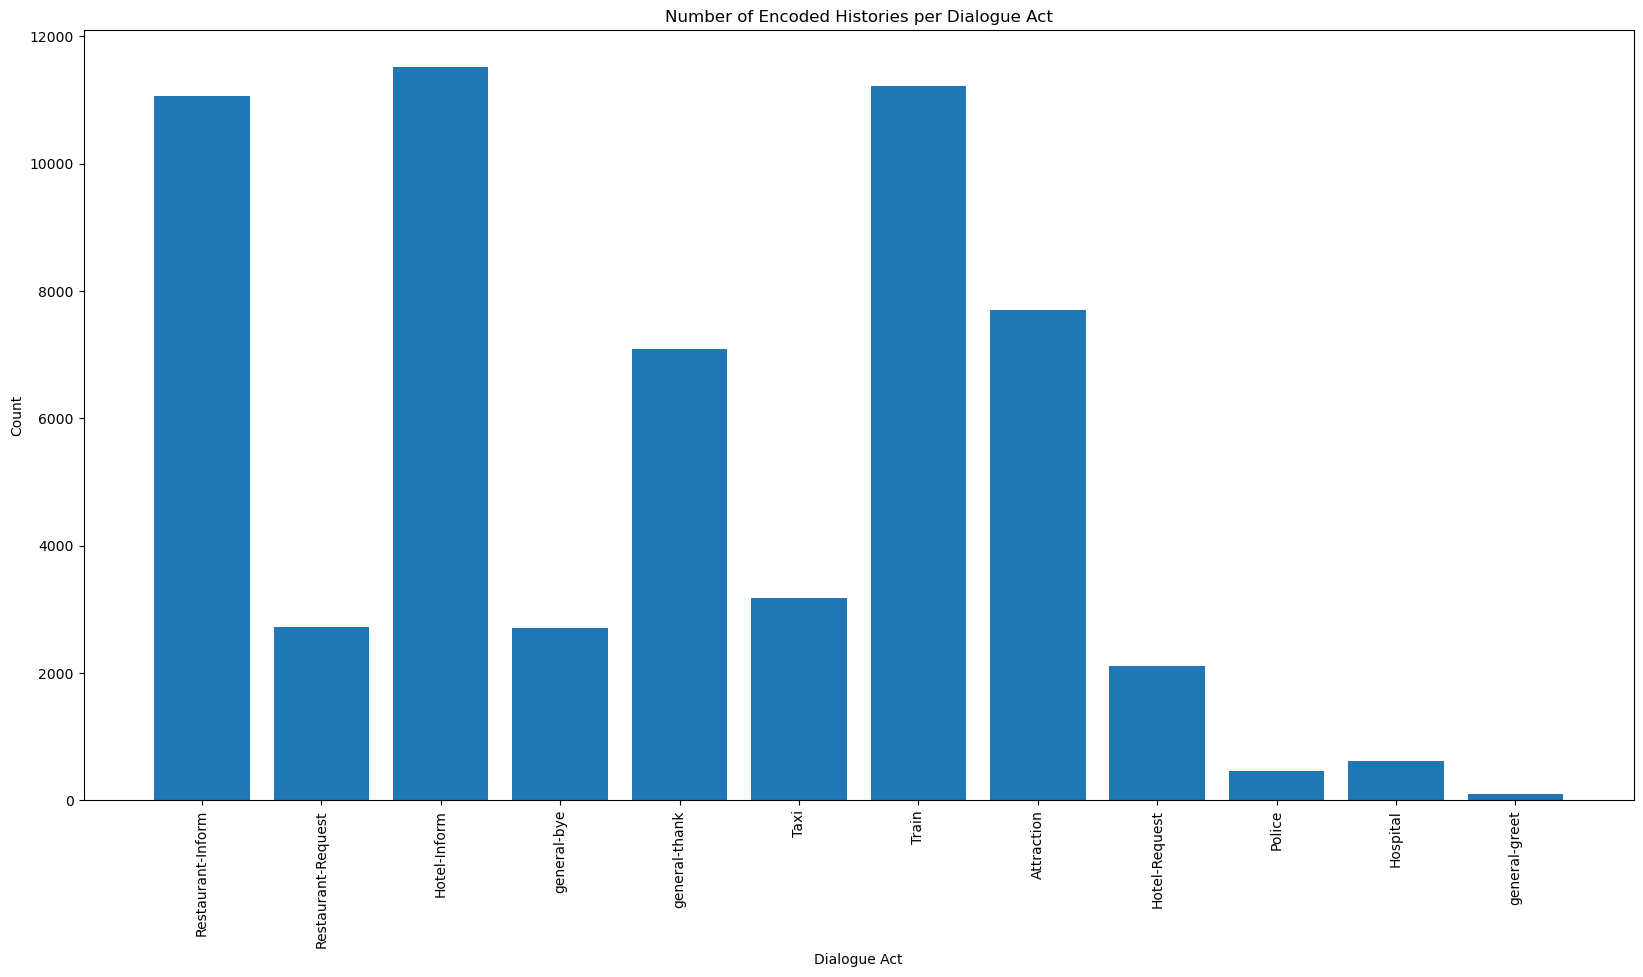

[('general-greet', 96), ('Police', 454), ('Hospital', 612), ('Hotel-Request', 2107), ('general-bye', 2700), ('Restaurant-Request', 2719), ('Taxi', 3184), ('general-thank', 7089), ('Attraction', 7703), ('Restaurant-Inform', 11064)]


In [16]:
# Generate a histogram of the number of Encoded History per dialogue act, knowing that there can be multiple dialogue acts per Encoded History. 
# To deal with this, we count as a separate Encoded Historyistory each time a dialogue act is present in an Encoded History, instead of counting more than one
# dialogue act per Encoded History.

# Initialize an empty dictionary to store the counts of each dialogue act
counts = {}

# Loop through each dialogue act array in the training data

for dialogue_act_array in Y_train:
        # Loop through each dialogue act in the dialogue act array
        for dialogue_act in dialogue_act_array:
            
            # If the dialogue act is already in the dictionary, increment its count by 1
            if dialogue_act in counts:
                counts[dialogue_act] += 1
            
            # If the dialogue act is not already in the dictionary, set its count to 1
            else:
                counts[dialogue_act] = 1

# Plot the histogram
plt.figure(figsize=(20, 10))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=90)
plt.xlabel('Dialogue Act')
plt.ylabel('Count')
plt.title('Number of Encoded Histories per Dialogue Act')
plt.show()

# Bottom 10 dialogue acts
sorted_counts = sorted(counts.items(), key=lambda item: item[1])
print(sorted_counts[:10])


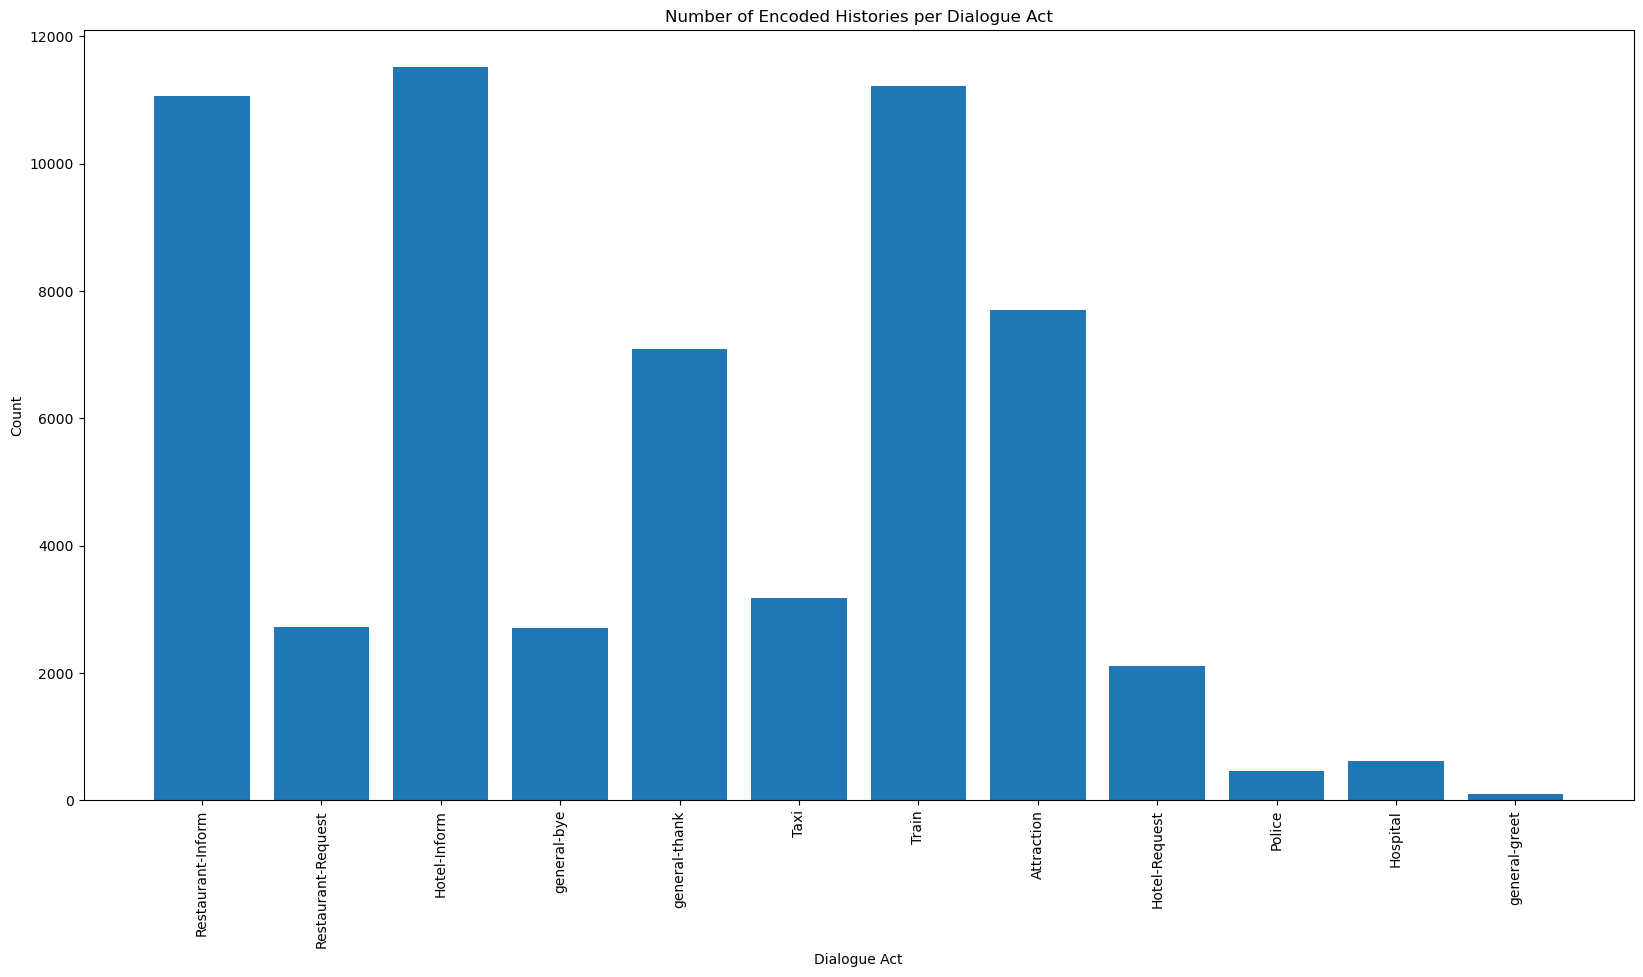

In [17]:

def prune_empty_dialogue_acts(X, Y):
    """
    Prunes the data to exclude Encoded Histories with no dialogue acts.

    Parameters:
    - X: list of Encoded Histories.
    - Y: list of lists of dialogue acts.

    Returns:
    - relabelled lists of Encoded Histories and dialogue acts.
    """
    # Initialize empty lists to store the pruned data
    X_pruned = []
    Y_pruned = []

    # Loop through each Encoded History and corresponding dialogue act array in the data
    for encoded_history, dialogue_act_array in zip(X, Y):

        # If the dialogue act array is not empty, append the Encoded History and dialogue act array to the pruned data
        if len(dialogue_act_array) > 0:
            X_pruned.append(encoded_history)
            Y_pruned.append(dialogue_act_array)
    
    return X_pruned, Y_pruned

# Prune empty dialogue acts for training, validation, and test data
X_pruned_train, Y_pruned_train = prune_empty_dialogue_acts(X_train, Y_train)
X_pruned_val, Y_pruned_val = prune_empty_dialogue_acts(X_val, Y_val)
X_pruned_test, Y_pruned_test = prune_empty_dialogue_acts(X_test, Y_test)
X_pruned_test_val, Y_pruned_test_val = prune_empty_dialogue_acts(X_test_val, Y_test_val)

# Generate a histogram of the number of Encoded Histories per dialogue act, knowing that there can be multiple dialogue acts per Encoded History.
# To deal with this, we count as a separate Encoded History each time a dialogue act is present in an Encoded History, instead of counting more than one
# dialogue act per Encoded History.

# Initialize an empty dictionary to store the counts of each dialogue act
counts = {}

# Loop through each dialogue act array in the training data

for dialogue_act_array in Y_pruned_train:
    # Loop through each dialogue act in the dialogue act array
    for dialogue_act in dialogue_act_array:
        
        # If the dialogue act is already in the dictionary, increment its count by 1
        if dialogue_act in counts:
            counts[dialogue_act] += 1
        
        # If the dialogue act is not already in the dictionary, set its count to 1
        else:
            counts[dialogue_act] = 1

# Plot the histogram
plt.figure(figsize=(20, 10))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=90)
plt.xlabel('Dialogue Act')
plt.ylabel('Count')
plt.title('Number of Encoded Histories per Dialogue Act')
plt.show()

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer


# Initialize a MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

# Fit the MultiLabelBinarizer object on the training data
mlb.fit(Y_pruned_train)

# Transform the training, validation, and test data
Y_encoded_train = mlb.transform(Y_pruned_train)
Y_encoded_val = mlb.transform(Y_pruned_val)
Y_encoded_test = mlb.transform(Y_pruned_test)
Y_encoded_test_val = mlb.transform(Y_pruned_test_val)

# Print the shape of the encoded training, validation, and test data
print(Y_encoded_train.shape)
print(Y_encoded_val.shape)
print(Y_encoded_test.shape)
print(Y_encoded_test_val.shape)

# Print the classes
print(mlb.classes_)
# Print the number of classes
print(len(mlb.classes_))

# Print the first 10 encoded training labels
print(Y_encoded_train[:10])

# Print the first 10 decoded training labels
print(mlb.inverse_transform(Y_encoded_train[:10]))

# Dump the MultiLabelBinarizer object to a pickle file
import pickle
pickle.dump(mlb, open('mlb.pkl', 'wb'))

(55811, 12)
(7235, 12)
(7258, 12)
(14493, 12)
['Attraction' 'Hospital' 'Hotel-Inform' 'Hotel-Request' 'Police'
 'Restaurant-Inform' 'Restaurant-Request' 'Taxi' 'Train' 'general-bye'
 'general-greet' 'general-thank']
12
[[0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]]
[('Restaurant-Inform',), ('Restaurant-Request',), ('Hotel-Inform', 'Restaurant-Request'), ('Hotel-Inform',), ('Hotel-Inform',), ('general-bye',), ('Hotel-Inform',), ('Hotel-Inform',), ('Hotel-Inform', 'Restaurant-Inform'), ('Hotel-Inform',)]


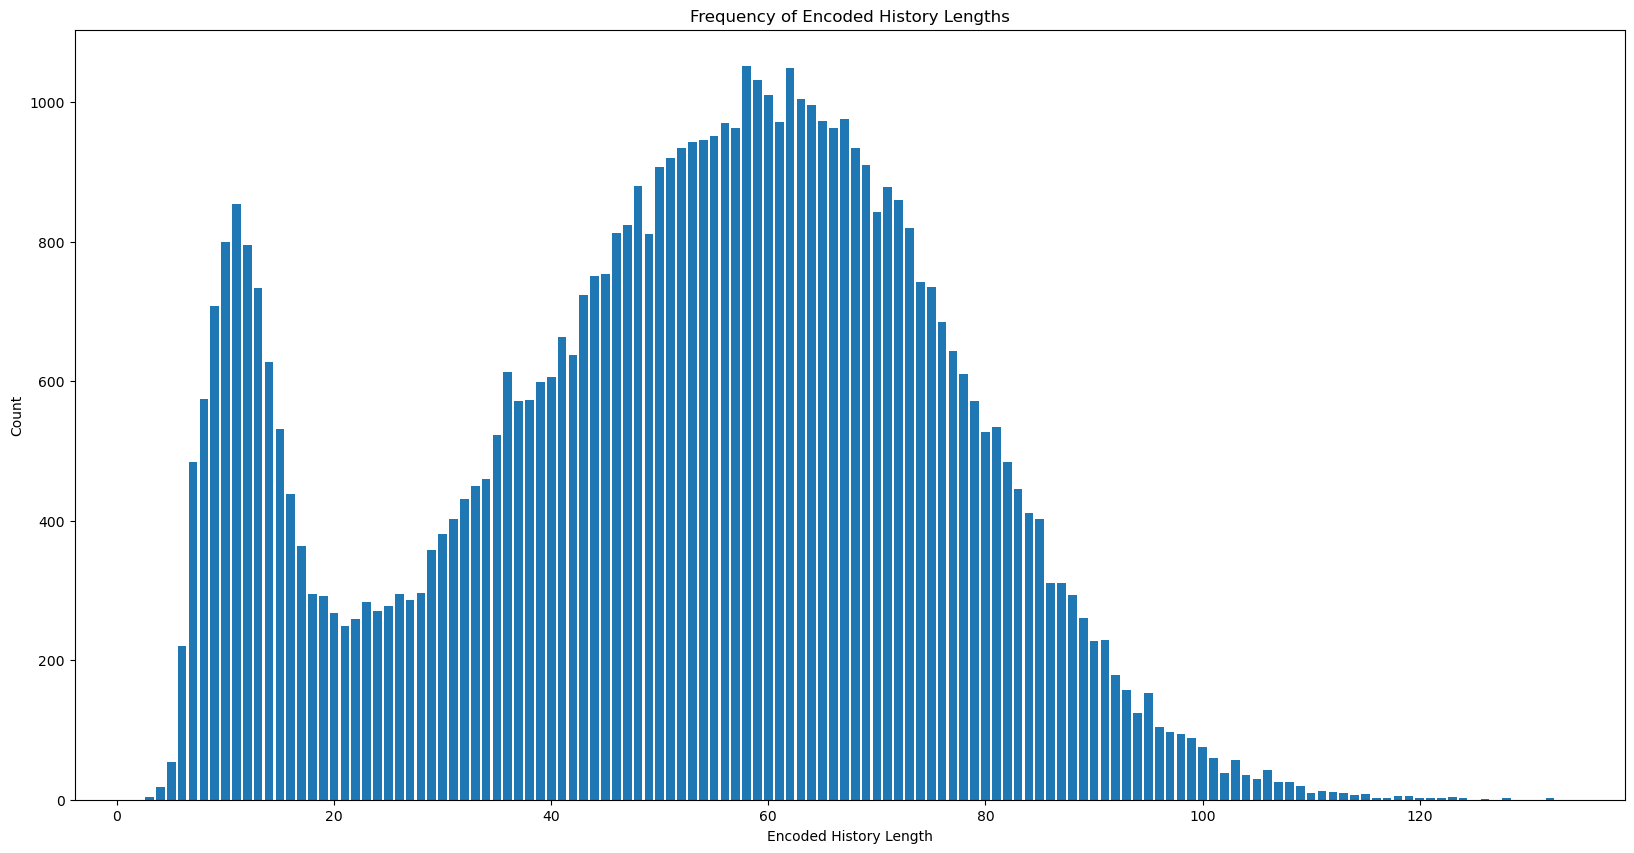

In [19]:
# Plot the frequency of Encoded History Lengths
# Initialize an empty dictionary to store the counts of each Encoded History length
counts = {}

# Loop through each Encoded History in the training data
for encoded_history in X_pruned_train:
    
    # Get the length of the utterance
    encoded_history_length = len(encoded_history.split())
    
    # If the Encoded History length is already in the dictionary, increment its count by 1
    if encoded_history_length in counts:
        counts[encoded_history_length] += 1
    
    # If the Encoded History length is not already in the dictionary, set its count to 1
    else:
        counts[encoded_history_length] = 1

# Plot the histogram
plt.figure(figsize=(20, 10))
plt.bar(counts.keys(), counts.values())
plt.xlabel('Encoded History Length')
plt.ylabel('Count')
plt.title('Frequency of Encoded History Lengths')
plt.show()


In [20]:
# Bert Models Enumeration
class BertModelsEnum(str, Enum):
    distilbert_base_uncased = 'distilbert-base-uncased'
    distilbert_base_cased = 'distilbert-base-cased'

bert_model_type = BertModelsEnum.distilbert_base_uncased.value
tokenizer = DistilBertTokenizer.from_pretrained(bert_model_type)
def tokenize_data(X, Y):
    input_encoded = []
    attention_masks = []
    labels = []
    for x,y in zip(X,Y):
        # Separate the history from the current utterance splitting by the last "|" character, but don't remove it
        history, utterance = x.rsplit("|", 1)
        
        # Merge the history and sentence into a single string adding a [SEP] token between them
        sentence = "".join(history) + " [SEP] " + utterance
        encoded = tokenizer.encode_plus(
            sentence, 
            add_special_tokens=True, 
            max_length=256, 
            padding='max_length', 
            truncation=True, 
            return_attention_mask=True)
        input_encoded.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        labels.append(y)
    return torch.tensor(input_encoded), torch.tensor(attention_masks), torch.tensor(labels)

train_input, train_masks, train_labels = tokenize_data(X_pruned_train, Y_encoded_train)
val_input, val_masks, val_labels = tokenize_data(X_pruned_val, Y_encoded_val)
test_input, test_masks, test_labels = tokenize_data(X_pruned_test, Y_encoded_test)
test_val_input, test_val_masks, test_val_labels = tokenize_data(X_pruned_test_val, Y_encoded_test_val)

C:\Users\berna\AppData\Local\Temp\ipykernel_20024\280581470.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  return torch.tensor(input_encoded), torch.tensor(attention_masks), torch.tensor(labels)


In [21]:
batch_size = 64 # Adjust based on GPU memory requirements
num_workers = 4 # Adjust based on the number of CPU cores

train_data = TensorDataset(train_input, train_masks, train_labels)
val_data = TensorDataset(val_input, val_masks, val_labels)
test_data = TensorDataset(test_input, test_masks, test_labels)
test_val_data = TensorDataset(test_val_input, test_val_masks, test_val_labels)

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
test_val_loader = DataLoader(test_val_data, batch_size=batch_size, num_workers=num_workers)

In [22]:
class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(bert_model_type)
        self.fc = nn.Linear(768, len(mlb.classes_))

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :] # selects the [CLS] token position.
        logits = torch.sigmoid(self.fc(cls_output))
        return logits

In [23]:
class SaveModelWithBestValLoss:
    """
    Class that saves the best model during a training process. If the current epoch's validation loss 
    is smaller than the previous smallest validation loss saved, it saves the model state.
    The best valid loss is initialized to infinity.
    """
    def __init__(
        self, smallest_valid_loss=float('inf')
    ):
        self.smallest_valid_loss = smallest_valid_loss
        
    def save(
        self, current_valid_loss, epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.smallest_valid_loss:
            self.smallest_valid_loss = current_valid_loss
            print(f"Saving best model for epoch {epoch+1}, with new best validation loss: {self.smallest_valid_loss}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'best_model.pth')

In [24]:
model = BertClassifier()
model = model.to(device)
 
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.BCELoss()

scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=40)

save_best_model_instance = SaveModelWithBestValLoss()

# For storing training and validation loss
train_losses = []
val_losses = []

lrs = []
for epoch in range(40):
    model.train()
    
    # Initialize tqdm progress bar
    #train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch}')
    
    train_loss = 0.0
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels.float())
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
        
        # Update training loss
        train_loss += loss.item()
        #train_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
    # Average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    val_loss = 0.0
    model.eval()

    # Initialize tqdm progress bar for validation
    #val_bar = tqdm(val_loader, desc=f'Validation Epoch {epoch}')
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            
            # Forward pass
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels.float())
            
            val_loss += loss.item()
            #val_bar.set_postfix({'validation_loss': '{:.3f}'.format(loss.item()/len(batch))})
            
    # Average validation loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    if len(val_losses) >= 4:
        diff_val_loss_1 = val_losses[-2] - val_losses[-1]
        diff_val_loss_2 = val_losses[-3] - val_losses[-1]
        diff_val_loss_3 = val_losses[-4] - val_losses[-1]
        if diff_val_loss_3 < 0 and diff_val_loss_2 < 0 and diff_val_loss_1 < 0:
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss} DID NOT IMPROVE')
            break
    
    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
    
    # Save model if validation model loss decreases
    save_best_model_instance.save(
        avg_val_loss, epoch, model, optimizer, criterion
    )

KeyboardInterrupt: 

In [ ]:
# Plotting validation and training loss
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# build the model, without loading the pre-trained weights or fine-tune layers
saved_model = BertClassifier().to(device)
best_model = torch.load('best_model.pth')
saved_model.load_state_dict(best_model['model_state_dict'])

In [ ]:
all_preds = []
all_labels = []

# Put the Saved Model in evaluation mode
saved_model.eval()

# Disable gradient computation
with torch.no_grad():
    # Initialize tqdm progress bar for Test
    test_bar = tqdm(test_loader, desc='Test')

    for batch in test_bar:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = saved_model(input_ids, attention_mask)

        # Get the predicted labels
        #_, preds = torch.max(logits, dim=1)

        # Move preds and labels to CPU for further evaluation (if using GPU)
        preds = logits.cpu().numpy()
        labels = labels.cpu().numpy()

        # Extend the list of predictions and labels
        all_preds.extend(preds)
        all_labels.extend(labels)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report
import numpy as np
threshold = 0.5
all_preds_binary = []
for all_pred in all_preds:
    local_pred = []
    for old_local_pred in all_pred:
        binary_local_pred = (old_local_pred > threshold).astype(int)
        local_pred.append(binary_local_pred)
    all_preds_binary.append(local_pred)

confusion_matrices = mcm(all_labels, all_preds_binary)
print(classification_report(all_labels, all_preds_binary, target_names=mlb.classes_))

# Plotting
n_labels = confusion_matrices.shape[0]
fig, axes = plt.subplots(n_labels, 1, figsize=(5, 5 * n_labels))

for i, (cm, ax) in enumerate(zip(confusion_matrices, axes)):
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(title=mlb.classes_[i], 
           ylabel='True label',
           xlabel='Predicted label',
           xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=['0', '1'], yticklabels=['0', '1'])

plt.tight_layout()
plt.show()

In [ ]:
# # Final Model
# model = BertClassifier()
# model = model.to(device)
 
# optimizer = optim.Adam(model.parameters(), lr=1e-5)
# criterion = nn.BCELoss()

# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=40)

# save_best_model_instance = SaveModelWithBestValLoss()

# # For storing training and validation loss
# train_losses = []
# val_losses = []

# lrs = []
# for epoch in range(45):
#     model.train()
    
#     # Initialize tqdm progress bar
#     #train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch}')
    
#     train_loss = 0.0
#     for batch in train_loader:
#         input_ids, attention_mask, labels = batch
#         input_ids = input_ids.to(device)
#         attention_mask = attention_mask.to(device)
#         labels = labels.to(device)

        
#         # Zero the parameter gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         logits = model(input_ids, attention_mask)
#         loss = criterion(logits, labels.float())
        
#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
        
#         lrs.append(optimizer.param_groups[0]["lr"])
#         scheduler.step()
        
#         # Update training loss
#         train_loss += loss.item()
#         #train_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
#     # Average training loss
#     avg_train_loss = train_loss / len(train_loader)
#     train_losses.append(avg_train_loss)
    
#     # Validation
#     val_loss = 0.0
#     model.eval()

#     # Initialize tqdm progress bar for validation
#     #val_bar = tqdm(test_val_loader, desc=f'Validation Epoch {epoch}')
    
#     with torch.no_grad():
#         for batch in test_val_loader:
#             input_ids, attention_mask, labels = batch
#             input_ids = input_ids.to(device)
#             attention_mask = attention_mask.to(device)
#             labels = labels.to(device)

            
#             # Forward pass
#             logits = model(input_ids, attention_mask)
#             loss = criterion(logits, labels.float())
            
#             val_loss += loss.item()
#             #val_bar.set_postfix({'validation_loss': '{:.3f}'.format(loss.item()/len(batch))})
            
#     # Average validation loss
#     avg_val_loss = val_loss / len(val_loader)
#     val_losses.append(avg_val_loss)
    
#     if len(val_losses) >= 4:
#         diff_val_loss_1 = val_losses[-2] - val_losses[-1]
#         diff_val_loss_2 = val_losses[-3] - val_losses[-1]
#         diff_val_loss_3 = val_losses[-4] - val_losses[-1]
#         if diff_val_loss_3 < 0 and diff_val_loss_2 < 0 and diff_val_loss_1 < 0:
#             print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss} DID NOT IMPROVE')
#             break
    
    
#     print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
    
#     # Save model if validation model loss decreases
#     save_best_model_instance.save(
#         avg_val_loss, epoch, model, optimizer, criterion
#     )

# import matplotlib.pyplot as plt
# plt.plot(train_losses, label='Training loss')
# plt.plot(val_losses, label='Validation loss')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()

In [ ]:
# # Plotting validation and training loss

# # build the model, without loading the pre-trained weights or fine-tune layers
# saved_model = BertClassifier().to(device)
# best_model = torch.load('best_model.pth', map_location=torch.device(device))
# saved_model.load_state_dict(best_model['model_state_dict'])

# all_preds = []
# all_labels = []

# # Put the Saved Model in evaluation mode
# saved_model.eval()

# # Disable gradient computation
# with torch.no_grad():
#     # Initialize tqdm progress bar for Test
#     test_bar = tqdm(test_val_loader, desc='Test')

#     for batch in test_bar:
#         input_ids, attention_mask, labels = batch
#         input_ids = input_ids.to(device)
#         attention_mask = attention_mask.to(device)
#         labels = labels.to(device)

#         # Forward pass
#         logits = saved_model(input_ids, attention_mask)

#         # Get the predicted labels
#         #_, preds = torch.max(logits, dim=1)

#         # Move preds and labels to CPU for further evaluation (if using GPU)
#         preds = logits.cpu().numpy()
#         labels = labels.cpu().numpy()

#         # Extend the list of predictions and labels
#         all_preds.extend(preds)
#         all_labels.extend(labels)

In [ ]:
# from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report
# import numpy as np
# threshold = 0.5
# all_preds_binary = []
# for all_pred in all_preds:
#     local_pred = []
#     for old_local_pred in all_pred:
#         binary_local_pred = (old_local_pred > threshold).astype(int)
#         local_pred.append(binary_local_pred)
#     all_preds_binary.append(local_pred)

# confusion_matrices = mcm(all_labels, all_preds_binary)
# print(classification_report(all_labels, all_preds_binary, target_names=mlb.classes_))
# acc_score = accuracy_score(all_labels, all_preds_binary)
# print(f"Accuracy (micro): {acc_score}")

# # Plotting
# n_labels = confusion_matrices.shape[0]
# fig, axes = plt.subplots(n_labels, 1, figsize=(5, 5 * n_labels))

# for i, (cm, ax) in enumerate(zip(confusion_matrices, axes)):
#     im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#     ax.figure.colorbar(im, ax=ax)
#     ax.set(title=mlb.classes_[i], 
#            ylabel='True label',
#            xlabel='Predicted label',
#            xticks=np.arange(cm.shape[1]),
#            yticks=np.arange(cm.shape[0]),
#            xticklabels=['0', '1'], yticklabels=['0', '1'])

# plt.tight_layout()
# plt.show()

In [ ]:
def predict(model, sentence, tokenizer):
    model.eval()
    
    encoded = tokenizer.encode_plus(
        sentence, 
        add_special_tokens=True, 
        max_length=256, 
        padding='max_length', 
        truncation=True, 
        return_attention_mask=True)
    
    input_ids = torch.tensor([encoded['input_ids']], dtype=torch.long).to(device)
    attention_mask = torch.tensor([encoded['attention_mask']], dtype=torch.long).to(device)
    
    # Make a prediction
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
    
    logits_cpu = logits.to('cpu')
    return logits_cpu.numpy()


sentence = "I would like to make a reservation for a table on October 12th."
preds = predict(saved_model, sentence, tokenizer)
threshold = 0.5
all_preds_binary = []
for all_pred in preds:
    local_pred = []
    for old_local_pred in all_pred:
        binary_local_pred = (old_local_pred > threshold).astype(int)
        local_pred.append(binary_local_pred)
    all_preds_binary.append(local_pred)
labels_preds = mlb.inverse_transform(np.array(all_preds_binary))
print("Predicted label:", labels_preds)


cuda


No config specified, defaulting to: multi_woz_v22/v2.2_active_only
Found cached dataset multi_woz_v22 (C:/Users/berna/.cache/huggingface/datasets/multi_woz_v22/v2.2_active_only/2.2.0/6719c8b21478299411a0c6fdb7137c3ebab2e6425129af831687fb7851c69eb5)


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\berna\anaconda3\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MultiLabelBinarizer from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


First 10 predictions
('Train',)
['Train', 'Train']
('Train',)
['Train', 'Train']
('Train',)
['Train', 'Train']
('Attraction',)
['Attraction', 'general-reqmore']
('general-thank',)
['general-bye']
First 10 ground truth
['Train']
['Train', 'Train']
['Train']
['Train', 'Train']
['Train']
['Train', 'Train']
['Attraction']
['Attraction', 'general-reqmore']
['general-thank']
['general-bye']


c:\Users\berna\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\berna\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\berna\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\berna\anaconda3\Lib\site-packages\sklearn\metrics\_cla

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1080
           1       0.00      0.00      0.00         0
           2       0.94      0.95      0.95      1328
           3       0.80      0.81      0.81       292
           4       1.00      1.00      1.00         1
           5       0.94      0.96      0.95      1323
           6       0.85      0.85      0.85       286
           7       0.95      0.97      0.96       410
           8       0.97      0.97      0.97      1729
           9       0.99      1.00      0.99       293
          10       0.75      0.50      0.60         6
          11       0.98      0.97      0.98       940

   micro avg       0.95      0.95      0.95      7688
   macro avg       0.84      0.83      0.83      7688
weighted avg       0.95      0.95      0.95      7688
 samples avg       0.96      0.95      0.95      7688

Accuracy (micro): 0.9187466087900162
[[[6243   49]
  [  49 1031]]

 [[7372    0

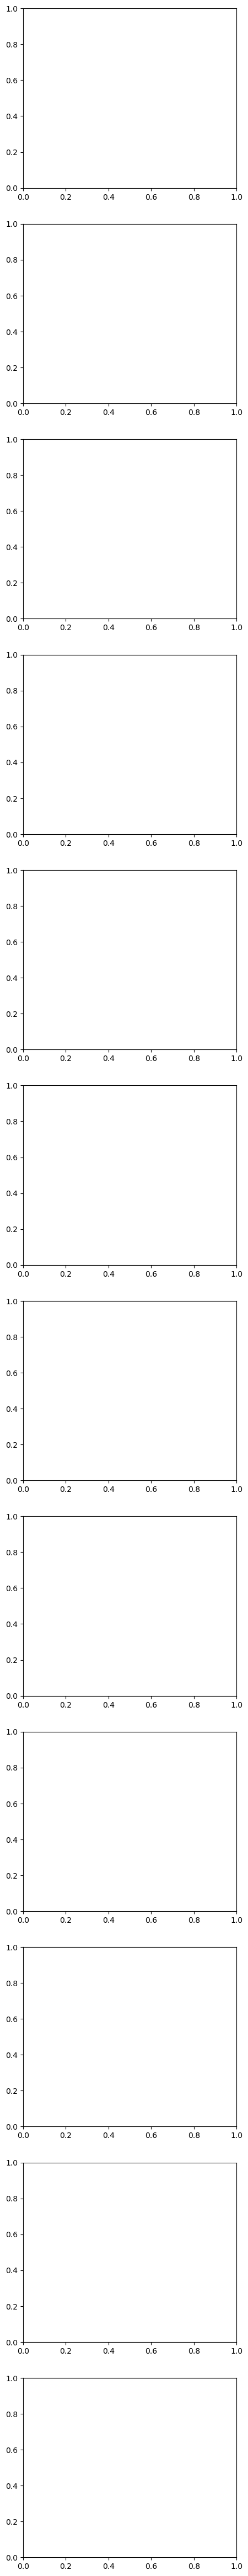

In [1]:
### Production Module
from typing import List
from pydantic import BaseModel
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import DistilBertTokenizer, DistilBertModel
from enum import Enum
import torch
import torch.nn as nn

# Use GPU if available
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

dataset = load_dataset("multi_woz_v22")
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

speaker_str = {0: 'User', 1: 'Agent'}
PAST_HISTORY_LENGTH = 2

class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(bert_model_type)
        self.fc = nn.Linear(768, len(mlb.classes_))

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :] # selects the [CLS] token position.
        logits = torch.sigmoid(self.fc(cls_output))
        return logits

class DialogItemIdentifier(BaseModel):
    id_dialog: str
    order_in_dialog: int

class DialogItem(BaseModel):
    id_dialog: str
    order_in_dialog: int
    utterance: str
    speaker: str
    dialogue_acts: List[str]
    gt_dialogue_acts: List[str]
    previous_dialog_items: List[DialogItemIdentifier] = []

def relabel_dialogue_act(dialogue_act: str):
    if dialogue_act.split('-')[0].upper() not in ['RESTAURANT', 'HOTEL', 'BOOKING', 'GENERAL']:
        new_dialog_act = dialogue_act.split('-')[0]
    else:
        new_dialog_act = dialogue_act

    return new_dialog_act


def convert_dialogitem_encoded_history(dialog_item: DialogItem, dialog_item_dataset: List[DialogItem], past_history_length: int = 2):
    """
    Converts a DialogItem object into an Encoded History string.

    Parameters:
    - dialog_item: DialogItem object.
    - dialog_item_dataset: List of DialogItem objects.
    - past_history_length: Length of the past history to consider.


    Returns:
    - Encoded History string.
    """
    encoded_history = ""

    # Initialize the history of the user and agent as lists with empty DialogItem objects
    agent_history: List[DialogItem] = []
    user_history: List[DialogItem] = []
    
    # For each identifier of the previous dialog items, search in the dialog_item_dataset for the corresponding DialogItem object
    # and append it to the agent or user history. If no DialogItem object is found, append a dialog item with empty utterance "" and dialogue acts []
    for i in range(len(dialog_item.previous_dialog_items)):
        for j in range(len(dialog_item_dataset)):
            if dialog_item_dataset[j].id_dialog == dialog_item.previous_dialog_items[i].id_dialog and dialog_item_dataset[j].order_in_dialog == dialog_item.previous_dialog_items[i].order_in_dialog:
                if dialog_item_dataset[j].speaker == "Agent":
                    agent_history.append(dialog_item_dataset[j])
                    # If the agent history is longer than the past history length, remove the oldest turn
                    if len(agent_history) > past_history_length:
                        agent_history.pop(0)
                elif dialog_item_dataset[j].speaker == "User":
                    user_history.append(dialog_item_dataset[j])
                    # If the user history is longer than the past history length, remove the oldest turn
                    if len(user_history) > past_history_length:
                        user_history.pop(0)

    # Fill up the encoded history of the user with the beggining of the array with DialogItems with empty utterance "" and dialogue acts [], for the amount
    # of turns that are missing to reach the past history length
    past_encoded_user_history = ""
    for i in range(past_history_length - len(user_history)):
        past_encoded_user_history += ">".join(["", ""]) + "|"
    for i in range(len(user_history)):
        past_encoded_user_history += ">".join([user_history[i].utterance, "_".join(user_history[i].dialogue_acts)]) + "|"

    # Fill up the encoded history of the agent with the beggining of the array with DialogItems with empty utterance "" and dialogue acts [], for the amount
    # of turns that are missing to reach the past history length
    past_encoded_agent_history = ""
    for i in range(past_history_length - len(agent_history)):
        past_encoded_agent_history += ">".join(["", ""]) + "|"
    
    for i in range(len(agent_history)):
        past_encoded_agent_history += ">".join([agent_history[i].utterance, "_".join(agent_history[i].dialogue_acts)]) + "|"

    encoded_history = past_encoded_user_history + past_encoded_agent_history + dialog_item.utterance

    return encoded_history

def initialize_dialogitem_dataset_from_raw_data(raw_data):
    """
    Initializes a list of DialogItem objects from the raw data, only for User turns

    Parameters:
    - raw_data: raw data from the MultiWOZ dataset.

    Returns:
    - List of DialogItem objects.
    """
    # Initialize an empty list to store the DialogItem objects
    dialog_items: List[DialogItem] = []

    # Loop through each dialogue in the raw data
    for dialogue in raw_data:

        # Get the number of turns in this dialogue
        num_turns = len(dialogue['turns']['utterance'])

        # Initialize an empty list to store the history of the user and agent
        dialog_past_history: List[DialogItemIdentifier] = []

        # Loop through each turn in the dialogue
        for i in range(num_turns):
            speaker = speaker_str[dialogue['turns']['speaker'][i]]

            # Extract the utterance and corresponding dialog act for this turn
            utterance = dialogue['turns']['utterance'][i]

            dialogue_act = dialogue['turns']['dialogue_acts'][i]['dialog_act']['act_type']
            dialogue_act_relabeled = []
            for j in range(len(dialogue_act)):
                dialogue_act_relabeled.append(relabel_dialogue_act(dialogue_act[j]))

            
           
            # If the speaker is the Agent, fill up the DAs since we know the dialog acts of our answers
            filled_dialogue_acts = []
            if speaker == "Agent":
                filled_dialogue_acts = dialogue_act_relabeled

            # Create a DialogItem object for this turn
            dialog_item = DialogItem(
                id_dialog=dialogue['dialogue_id'],
                order_in_dialog=i,
                utterance=utterance,
                speaker=speaker,
                dialogue_acts=filled_dialogue_acts,
                gt_dialogue_acts=dialogue_act_relabeled,
                previous_dialog_items=dialog_past_history
            )

            # Append the DialogItem object to the list of DialogItem objects
            dialog_items.append(dialog_item)

            # Append the DialogItemIdentifier object to the history of the user and agent
            dialog_item_identifier = DialogItemIdentifier(
                id_dialog=dialogue['dialogue_id'],
                order_in_dialog=i
            )
            dialog_past_history.append(dialog_item_identifier)

            # If the history of the user and agent is longer than the past history length multiplied by two, which guarantees that this wont fail on the conversion and speeds up the process
            # , remove the oldest turn
            if len(dialog_past_history) > PAST_HISTORY_LENGTH*2:
                dialog_past_history.pop(0)

    return dialog_items

def predict(model, sentence, tokenizer):
    model.eval()

    # Separate the history from the current utterance splitting by the last "|" character, but don't remove it
    history, utterance = sentence.rsplit("|", 1)
    
    # Merge the history and sentence into a single string adding a [SEP] token between them
    sentence = "".join(history) + " [SEP] " + utterance
    
    encoded = tokenizer.encode_plus(
        sentence, 
        add_special_tokens=True, 
        max_length=256, 
        padding='max_length', 
        truncation=True, 
        return_attention_mask=True)
    
    input_ids = torch.tensor([encoded['input_ids']], dtype=torch.long).to(device)
    attention_mask = torch.tensor([encoded['attention_mask']], dtype=torch.long).to(device)
    
    # Make a prediction
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
    
    logits_cpu = logits.to('cpu')
    return logits_cpu.numpy()

def predict_da(dialog_item_dataset: List[DialogItem], model: BertClassifier, tokenizer: DistilBertTokenizer, multilabelbinarizer: MultiLabelBinarizer):
    """
    Predicts the dialogue act of every User turn in the dialog, filling up the dialog acts of previous dialog items in the same dialog with the previous prediction.
    only for the User. For the Agent, the DAs are filled using the ground truth from the pre-processing function and it arrives here filled, since
    we know what dialog acts the agent is performing.

    Parameters:
    - dialog_item_dataset: List of DialogItem objects.
    - model: BertClassifier model.
    - tokenizer: DistilBertTokenizer object.
    - multilabelbinarizer: MultiLabelBinarizer object.

    Returns:
    - List of predicted dialogue acts, only for User utterances.
    """
    dataset_copy = dialog_item_dataset.copy()

    # Loop through each DialogItem object in the dataset
    for dialog_item in dataset_copy:

        # If the speaker is the User, predict the dialogue act
        if dialog_item.speaker == "User":
            encoded_history = convert_dialogitem_encoded_history(dialog_item, dataset_copy)
            preds = predict(model, encoded_history, tokenizer)
            threshold = 0.5
            all_preds_binary = []
            for all_pred in preds:
                local_pred = []
                for old_local_pred in all_pred:
                    binary_local_pred = (old_local_pred > threshold).astype(int)
                    local_pred.append(binary_local_pred)
                all_preds_binary.append(local_pred)
            labels_preds = multilabelbinarizer.inverse_transform(np.array(all_preds_binary))
            dialog_item.dialogue_acts = labels_preds[0]

    return dataset_copy


# Load the MultiLabelBinarizer object
import pickle
mlb = pickle.load(open('mlb.pkl', 'rb'))

class BertModelsEnum(str, Enum):
    distilbert_base_uncased = 'distilbert-base-uncased'
    distilbert_base_cased = 'distilbert-base-cased'

bert_model_type = BertModelsEnum.distilbert_base_uncased.value

# Load the best model
saved_model = BertClassifier().to(device)
best_model = torch.load('best_model.pth', map_location=torch.device(device))
saved_model.load_state_dict(best_model['model_state_dict'])

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(bert_model_type)

# Initialize the dataset
dialog_item_dataset = initialize_dialogitem_dataset_from_raw_data(test_data)

# Predict the dialogue acts
dialog_item_dataset_predicted = predict_da(dialog_item_dataset, saved_model, tokenizer, mlb)

# Print the first 10 predicted dialogue acts
print("First 10 predictions")
for dialog_item in dialog_item_dataset_predicted[:10]:
    print(dialog_item.dialogue_acts)

# Print the first 10 ground truth dialogue acts
print("First 10 ground truth")
for dialog_item in dialog_item_dataset[:10]:
    print(dialog_item.gt_dialogue_acts)

# Compute a classification report comparing to the ground truth
from sklearn.metrics import classification_report
y_true = []
y_pred = []
for dialog_item in dialog_item_dataset:
    if dialog_item.speaker == "User":
        y_true.append(dialog_item.gt_dialogue_acts)
        y_pred.append(dialog_item.dialogue_acts)

y_true_binary = mlb.transform(y_true)
y_pred_binary = mlb.transform(y_pred)
print(classification_report(y_true_binary, y_pred_binary)) 

# Compute the accuracy
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_true_binary, y_pred_binary)
print(f"Accuracy (micro): {acc_score}")

# Compute the confusion matrix
from sklearn.metrics import multilabel_confusion_matrix as mcm
confusion_matrices = mcm(y_true_binary, y_pred_binary)
print(confusion_matrices)

# Plot the confusion matrix
import matplotlib.pyplot as plt
n_labels = confusion_matrices.shape[0]
fig, axes = plt.subplots(n_labels, 1, figsize=(5, 5 * n_labels))

